## Objetivo

Gerar ilustrações para as características de cada defeito. 

Na inicialização abaixo são selecionadas amostras com a *maior severidade* de defeito, na *maior rotação*.

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from initialize import Measurement


sns.set_theme()
sns.set_context("notebook", font_scale=1.2)

# escolhe exemplares
NORMAL = '../mafaulda/normal/0/'
DESBALANCEAMENTO = '../mafaulda/imbalance/35g/'
DESALINHAMENTO_VERTICAL = '../mafaulda/vertical-misalignment/1.90mm/'
DESALINHAMENTO_HORIZONTAL = '../mafaulda/horizontal-misalignment/1.5mm/'

# escolhe e agrupa exemplares (i_max=44)
i=44
CAMINHOS = []
for defeito in [NORMAL, DESBALANCEAMENTO, DESALINHAMENTO_VERTICAL, DESALINHAMENTO_HORIZONTAL]:
    caminho = defeito + os.listdir(defeito)[i]
    CAMINHOS.append(caminho)

# define eixo visualizado
EIXO = 'tg1'

# outros nomes
NOMES_DEFEITOS = (['Normal', 'Desbalanceamento\n35 g', 'Desal. vertical\n1,9 mm', 'Desal. horizontal\n1,5 mm'])
FREQUENCIA = 'Frequência (Hz)'
print(CAMINHOS)

['../mafaulda/normal/0/57.9584.csv', '../mafaulda/imbalance/35g/56.7296.csv', '../mafaulda/vertical-misalignment/1.90mm/56.7296.csv', '../mafaulda/horizontal-misalignment/1.5mm/57.1392.csv']


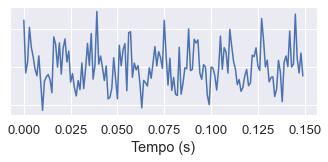

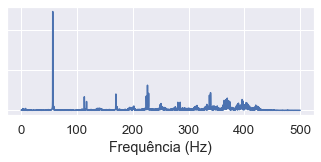

In [2]:
m = Measurement(CAMINHOS[0],50)
m.time['tempo'] = np.linspace(0,5,m.time.shape[0])

plt.figure(figsize=(5.5,2))
ax = sns.lineplot(data=m.time[:150], x='tempo', y='rad1')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Tempo (s)')
plt.savefig('../redacao/figuras/transform_time.pdf', bbox_inches='tight')

plt.figure(figsize=(5.5,2))
ax = sns.lineplot(data=m.freq, x='freq_ax', y='rad1')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Frequência (Hz)')

plt.savefig('../redacao/figuras/transform_freq.pdf', bbox_inches='tight')

Agora realizando a leitura e agrupando os dataframes

In [3]:
# listas que reúnem os dados
dataframes = []
arg_rotacao_calcs = []
harmonics = []

# itera para cada mensuração 
for i, exemplar in enumerate(CAMINHOS):
    m = Measurement(exemplar,50)
    dataframes.append(m.freq[['freq_ax', EIXO]])
    arg_rotacao_calcs.append(m.rotacao_calc)
    harmonics.append(m.harmonics.T[['freq_ax', EIXO]])

# reúne todas as mensurações em um único DF
df = pd.concat(dataframes, 
          keys=NOMES_DEFEITOS, 
          names=['Condição', 'index']
).reset_index()
df.pop('index')

df = pd.concat(dataframes, 
          keys=NOMES_DEFEITOS, 
          names=['Condição', 'index']
).reset_index()
df.pop('index')

harmonics_df = pd.concat(harmonics, 
          keys=NOMES_DEFEITOS, 
          names=['Condição', 'index']
).reset_index()
harmonics_df.pop('index')

# estiliza nomes de colunas e mostra-as
df.rename(columns={EIXO: 'Amplitude', 'freq_ax': FREQUENCIA}, inplace=True)
list(df.columns)

['Condição', 'Frequência (Hz)', 'Amplitude']

Agora podemos visualizar o espectro da frequência no eixo selecionado e nas leituras escolhidas.

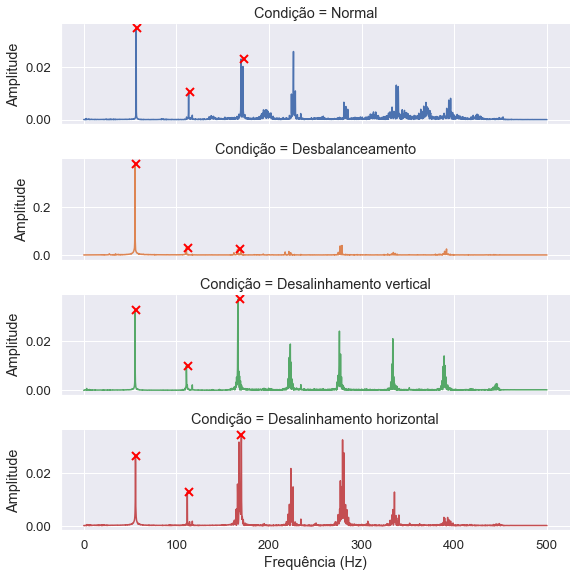

In [4]:
facet = sns.relplot(
    data=df, x=FREQUENCIA, y='Amplitude', row='Condição', kind='line', 
    facet_kws={'sharey': False, 'sharex': True}, height=2, aspect=4, hue='Condição', legend=False
)

for i, condicao in enumerate(NOMES_DEFEITOS):
    data = harmonics_df.query(f"Condição == '{condicao}'")
    facet.axes[i][0].plot(data['freq_ax'], data[EIXO], 'x', color='red', mew=2, ms=8)

# plt.savefig('../redacao/figuras/exemplares.pdf', bbox_inches='tight')

plt.show()

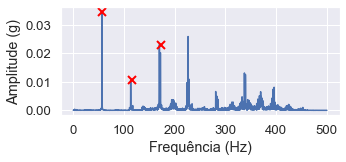

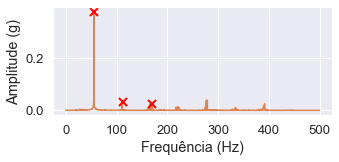

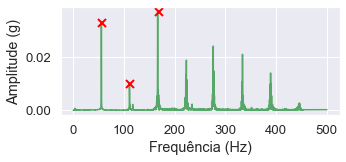

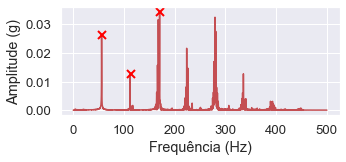

In [6]:
colors = plt.rcParams["axes.prop_cycle"]()

def plot_condicao(condicao):
    c = next(colors)["color"]
    data=df.query(f"Condição == '{condicao}'")
    data_ponits = harmonics_df.query(f"Condição == '{condicao}'")
    
    plt.subplots(figsize=(5,2))
    plt.plot(data[FREQUENCIA], data['Amplitude'], color=c)
    plt.plot(data_ponits['freq_ax'], data_ponits[EIXO], 'x', color='red', mew=2, ms=8)
    plt.xlabel(FREQUENCIA)
    plt.ylabel("Amplitude (g)")

plot_condicao('Normal')
plt.savefig('../redacao/figuras/espectro_normal.pdf', bbox_inches='tight')

plot_condicao('Desbalanceamento')
plt.savefig('../redacao/figuras/espectro_desbal.pdf', bbox_inches='tight')

plot_condicao('Desalinhamento vertical')
plt.savefig('../redacao/figuras/espectro_desver.pdf', bbox_inches='tight')

plot_condicao('Desalinhamento horizontal')
plt.savefig('../redacao/figuras/espectro_deshor.pdf', bbox_inches='tight')

Também podemos ver o periodigrama (o FFT ao quadrado). Ele fornece uma visão mais clara dos picos.

In [147]:
[[np.nan]*6]*4

[[nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan]]

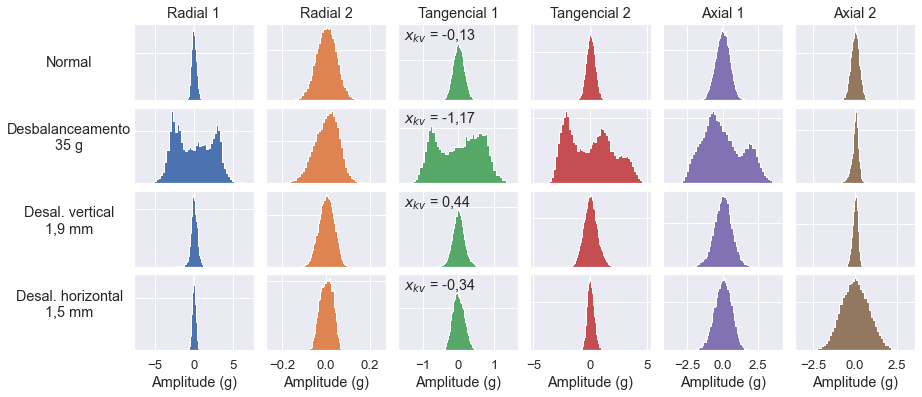

In [181]:
def corrige_nome_eixos(nome):
    return nome.replace('rad', 'Radial ').replace('tg', 'Tangencial ').replace('ax', 'Axial ')

fig, axs = plt.subplots(4, 6, figsize=(14,6), sharex='col')

xabs_max = [0]*6
kurt_matrix = np.empty((4,6))
kurt_matrix.fill(np.nan)

for i, exemplar in enumerate(CAMINHOS):
    m = Measurement(exemplar,10)
    axs[i][0].set_ylabel(NOMES_DEFEITOS[i], rotation=0, labelpad=55, y=.4)
    
    for j, col in enumerate(m.time_acc):
        axs[i][j].hist(m.time_acc[col], bins=50, histtype='stepfilled', color=f'C{j}')
        axs[i][j].set_yticklabels([])
        axs[0][j].set_title(corrige_nome_eixos(col))
        xabs_max_j = abs(max(axs[i][j].get_xlim(), key=abs))
        if xabs_max_j > xabs_max[j]:
            xabs_max[j]=xabs_max_j
        
        y_max = max(axs[i][j].get_ylim())
       
        
        if j==2:
            axs[i][j].set_ylim(ymax=y_max*1.25)
            kurt_matrix[i][j] = m.time_acc[col].kurtosis()
#             axs[i,j].annotate('$x_{{kv}}$ = {:.2f}'.format(kurt_matrix[i][j]).replace('.',','), xy=(-0.9*xabs_max_j, y_max*.8), weight=3)
#             crsit_f = m.time_acc[col].abs().max() / m.time_acc[col].pow(2).mean() ** 1/2
#             axs[i,j].annotate('cf = {:.2f}'.format(crsit_f).replace('.',','), xy=(-0.9*xabs_max_j, y_max*.6), weight=3)

    

for j in range(6):
    axs[3][j].set_xlim(xmin=-xabs_max[j], xmax=xabs_max[j])
    axs[3][j].set_xlabel('Amplitude (g)')

for i in range(4):
    for j in range(6):
        kurt = kurt_matrix[i][j]
        if ~np.isnan(kurt):
            axs[i,j].annotate('$x_{{kv}}$ = {:.2f}'.format(kurt).replace('.',','), xy=(-0.9*xabs_max[j], max(axs[i][j].get_ylim())*.8), weight=3)
            

plt.subplots_adjust(wspace = 0.1, hspace=0.1)
# plt.savefig('../redacao/figuras/distribuicao_exemplos.pdf', bbox_inches='tight')

In [169]:
a = np.empty((4,6))
a.fill(np.nan)
a[2][5]

nan

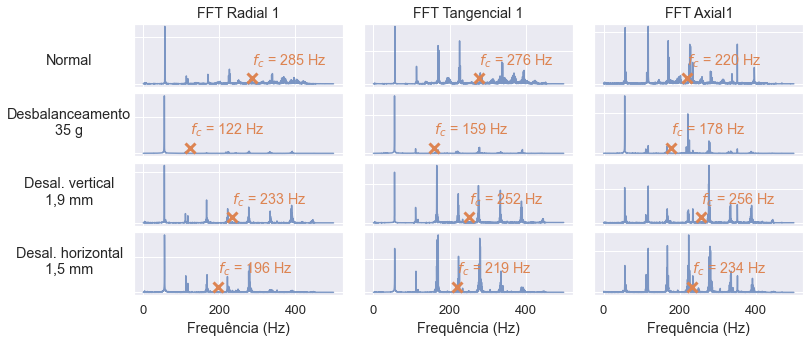

In [101]:
import matplotlib.lines as mlines

fig, axs = plt.subplots(4, 3, figsize=[12,5], sharex='col')

for i, exemplar in enumerate(CAMINHOS):
    m =  Measurement(exemplar, 50)

    accelerations_fft = m.freq_acc.iloc[:,:-1]
    freq_ax = m.freq_acc['freq_ax']

    fc_cols = (freq_ax * accelerations_fft.T).T.sum() / accelerations_fft.sum()
    axs[i][0].set_ylabel(NOMES_DEFEITOS[i], rotation=0, labelpad=55, y=.3)
    for j in range(3):
        col = j*2

        f_c = fc_cols[col]

        axs[i,j].plot(freq_ax, accelerations_fft.iloc[:,col], alpha=0.7)
        axs[0,j].set_title('FFT ' + corrige_nome_eixos(accelerations_fft.columns[col]))
        axs[i,j].set_yticklabels([])
        
        y_max = max(accelerations_fft.iloc[:,col])
        axs[i,j].plot(f_c, y_max*1/10, "x", markersize=10, color='C1', mew=3)
        axs[3,j].set_xlabel('Frequência (Hz)')
        
        axs[i,j].annotate('$f_c$ = {:.0f} Hz'.format(f_c).replace('.',','), xy=(f_c, y_max*1/3), color='C1', weight=3)


plt.subplots_adjust(wspace = 0.1, hspace=0.1)    
# plt.savefig(f'../redacao/figuras/sinais_frequencia{mancal}.pdf', bbox_inches='tight')
